LaTeX macros (hidden cell)
$
\newcommand{\Q}{\mathcal{Q}}
\newcommand{\ECov}{\boldsymbol{\Sigma}}
\newcommand{\EMean}{\boldsymbol{\mu}}
\newcommand{\EAlpha}{\boldsymbol{\alpha}}
\newcommand{\EBeta}{\boldsymbol{\beta}}
$

# Imports and configuration

In [13]:
import sys
import os
import re
import datetime as dt

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from mosek.fusion import *
import mosek.fusion.pythonic   # Requires MOSEK >= 10.2

from portfolio_tools import data_download, DataReader, compute_inputs

In [14]:
# Version checks
print(sys.version)
print('matplotlib: {}'.format(matplotlib.__version__))

# Numpy options
np.set_printoptions(precision=5, linewidth=120, suppress=True)

# Pandas options
pd.set_option('display.max_rows', None)

# Matplotlib options
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

3.11.6 (main, Oct  8 2023, 05:06:43) [GCC 13.2.0]
matplotlib: 3.8.2


# Prepare input data

Here we load the raw data that will be used to compute the optimization input variables, the vector $\EMean$ of expected returns and the covariance matrix $\ECov$. The data consists of daily stock prices of $8$ stocks from the US market. 

## Download data

In [15]:
# Data downloading:
# If the user has an API key for alphavantage.co, then this code part will download the data.
# The code can be modified to download from other sources. To be able to run the examples,
# and reproduce results in the cookbook, the files have to have the following format and content:
# - File name pattern: "daily_adjusted_[TICKER].csv", where TICKER is the symbol of a stock.
# - The file contains at least columns "timestamp", "adjusted_close", and "volume".
# - The data is daily price/volume, covering at least the period from 2016-03-18 until 2021-03-18,
# - Files are for the stocks PM, LMT, MCD, MMM, AAPL, MSFT, TXN, CSCO.
list_stocks = ["PM", "LMT", "MCD", "MMM", "AAPL", "MSFT", "TXN", "CSCO"]
list_factors = []
alphaToken = None

list_tickers = list_stocks + list_factors
if alphaToken is not None:
    data_download(list_tickers, alphaToken)

## Read data

We load the daily stock price data from the downloaded CSV files. The data is adjusted for splits and dividends. Then a selected time period is taken from the data.

In [16]:
investment_start = "2016-03-18"
investment_end = "2021-03-18"

In [17]:
# The files are in "stock_data" folder, named as "daily_adjusted_[TICKER].csv"
dr = DataReader(folder_path="stock_data", symbol_list=list_tickers)
dr.read_data()
df_prices, _ = dr.get_period(start_date=investment_start, end_date=investment_end)

Found data files: 
stock_data/daily_adjusted_AAPL.csv
stock_data/daily_adjusted_PM.csv
stock_data/daily_adjusted_CSCO.csv
stock_data/daily_adjusted_TXN.csv
stock_data/daily_adjusted_MMM.csv
stock_data/daily_adjusted_IWM.csv
stock_data/daily_adjusted_MCD.csv
stock_data/daily_adjusted_SPY.csv
stock_data/daily_adjusted_MSFT.csv
stock_data/daily_adjusted_LMT.csv

Using data files: 
stock_data/daily_adjusted_PM.csv
stock_data/daily_adjusted_LMT.csv
stock_data/daily_adjusted_MCD.csv
stock_data/daily_adjusted_MMM.csv
stock_data/daily_adjusted_AAPL.csv
stock_data/daily_adjusted_MSFT.csv
stock_data/daily_adjusted_TXN.csv
stock_data/daily_adjusted_CSCO.csv



# Run the optimization

## Define the optimization model

Below we implement the optimization model in Fusion API. We create it inside a function so we can call it later.

In this model, the gross exposure is kept on a constant level. This can be modeled by separating the portfolio variable to positive and negative part, and constraining their sum. The tradeoff is that modeling positive and negative parts requires us to assign each part a binary vector. Thus the problem becomes mixed integer. 

In [18]:
# x = xp - xm
# NOTE: Uses integer variables!
def posneg(M, x, bigm_p, bigm_m=None):
    bigm_m = bigm_p if bigm_m is None else bigm_m

    # Positive and negative part of x
    xp = M.variable("_xp", N, Domain.greaterThan(0.0))
    xm = M.variable("_xm", N, Domain.greaterThan(0.0))

    # Binary variables
    yp = M.variable("_yp", N, Domain.binary())
    ym = M.variable("_ym", N, Domain.binary())

    # Constraint assigning xp and xm to be the positive and negative part of x.
    M.constraint('_pos-neg-part', x == xp - xm)

    # Constraints making sure xp and xm are never both positive.
    M.constraint('_ubound-p', xp <= bigm_p * yp)
    M.constraint('_ubound-m', xm <= bigm_m * ym)
    M.constraint('_exclusion', yp + ym <= 1)

    return xp, xm, yp, ym

# ||x||_1 in domain
# NOTE: Uses integer variables!
def norm1_mio(M, x, bigm, domain):
    xp, xm, _, _ = posneg(M, x, bigm)

    # Gross exposure constraint (forces 2 times the initial capital)
    M.constraint('gross_exp', Expr.sum(xp + xm), domain)

def EfficientFrontier(N, m, G, deltas):

    with Model("Case study") as M:
        # Settings
        # M.setLogHandler(sys.stdout)
        # Set a work limit
        M.setSolverParam("mioMaxNumBranches", max(1000, N * 25))
        # Reuse feasible solution from previus iteration
        M.setSolverParam("mioConstructSol", "on")
        # Variables
        # The variable x is the fraction of holdings relative to the initial capital.
        # It is a free variable, allowing long and short positions.
        x = M.variable("x", N, Domain.unbounded())

        # The variable s models the portfolio variance term in the objective.
        s = M.variable("s", 1, Domain.unbounded())

        # Gross exposure constraint ||x||_1 = 2
        norm1_mio(M, x, 2.0, Domain.equalsTo(2.0))

        # Dollar neutrality constraint
        M.constraint('neutrality', Expr.sum(x) == 0.0)

        # Objective (quadratic utility version)
        delta = M.parameter()
        M.objective('obj', ObjectiveSense.Maximize, x.T @ m - delta * s)

        # Conic constraint for the portfolio variance
        M.constraint('risk', Expr.vstack(s, 0.5, G.T @ x), Domain.inRotatedQCone())

        # Create DataFrame to store the results. Last security name (the SPY) is removed.
        columns = ["delta", "obj", "return", "risk", "g. exp.", "time"] + df_prices.columns.tolist()
        df_result = pd.DataFrame(columns=columns)
        for d in deltas:
            # Update parameter
            delta.setValue(d)

            # Accept feasible or optimal solutions
            M.acceptedSolutionStatus(AccSolutionStatus.Feasible)

            # Solve optimization
            M.solve()

            # Check if the solution is an optimal or feasible
            solsta = M.getPrimalSolutionStatus()
            if (solsta not in [SolutionStatus.Optimal, SolutionStatus.Feasible]):
                # See https://docs.mosek.com/latest/pythonfusion/accessing-solution.html about handling solution statuses.
                raise Exception("Unexpected solution status!")

            # Save results
            portfolio_return = m @ x.level()
            portfolio_risk = np.sqrt(s.level()[0])
            gross_exp = sum(np.absolute(x.level()))
            time_spent = M.getSolverDoubleInfo("mioTime")
            row = pd.Series([d, M.primalObjValue(), portfolio_return, portfolio_risk, gross_exp, time_spent] + list(x.level()), index=columns)
            df_result = pd.concat([df_result, pd.DataFrame([row])], ignore_index=True)

        return df_result

## Compute optimization input variables

Here we use the loaded daily price data to compute the corresponding yearly mean return and covariance matrix.

In [19]:
# Number of securities
N = df_prices.shape[1]

# Get optimization parameters
m, S = compute_inputs(df_prices)

Next we compute the matrix $G$ such that $\ECov=GG^\mathsf{T}$, this is the input of the conic form of the optimization problem. Here we use Cholesky factorization.

In [20]:
G = np.linalg.cholesky(S)
m

array([0.07197, 0.15518, 0.17535, 0.08981, 0.42896, 0.39292, 0.32171, 0.18379])

## Call the optimizer function

We run the optimization for a range of risk aversion parameter values: $\delta = 10^{-1},\dots,10^{1.5}$. We compute the efficient frontier this way both with and without using shrinkage estimation. 

In [21]:
# Compute efficient frontier with and without shrinkage
deltas = np.logspace(start=-1, stop=1.5, num=20)
df_result = EfficientFrontier(N, m, G, deltas)

/tmp/ipykernel_30105/3198300836.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_result = pd.concat([df_result, pd.DataFrame([row])], ignore_index=True)


Check the results.

In [22]:
df_result

,delta,obj,return,risk,g. exp.,time,PM,LMT,MCD,MMM,AAPL,MSFT,TXN,CSCO
0,0.100000,0.341122,0.356984,0.398270,2.0,0.003684,-1.000000,-1.526906e-08,-1.037056e-08,-1.589652e-07,1.000000,8.170442e-08,1.595604e-08,-9.102509e-09
1,0.135388,0.335509,0.356984,0.398270,2.0,0.001476,-1.000000,-1.526906e-08,-1.037056e-08,-1.589652e-07,1.000000,8.170442e-08,1.595604e-08,-9.102509e-09
2,0.183298,0.327910,0.356984,0.398270,2.0,0.001586,-1.000000,-7.151764e-09,-4.540777e-09,-7.987992e-08,1.000000,1.677462e-07,1.130004e-08,-3.938796e-09
3,0.248163,0.317929,0.353401,0.378071,2.0,0.003791,-0.889708,-4.177768e-09,-2.933052e-09,-1.102921e-01,0.955155,4.484488e-02,2.332605e-09,-4.918404e-10
4,0.335982,0.306991,0.344283,0.333158,2.0,0.001486,-0.766838,9.456043e-10,-3.855922e-09,-2.331618e-01,0.762954,2.370460e-01,1.054586e-08,-5.272349e-09
5,0.454878,0.294985,0.337550,0.305898,2.0,0.001434,-0.676092,1.330003e-10,-6.467388e-10,-3.239084e-01,0.621046,3.789544e-01,4.578437e-09,-9.522782e-10
6,0.615848,0.280802,0.332578,0.289952,2.0,0.002487,-0.609090,1.962250e-09,-5.080767e-09,-3.909104e-01,0.516253,4.837467e-01,2.326047e-08,-7.772700e-09
7,0.833782,0.263130,0.328905,0.280869,2.0,0.002591,-0.559601,3.824761e-09,-2.383194e-09,-4.403995e-01,0.438835,5.611644e-01,6.359067e-08,-6.916866e-09
8,1.128838,0.240334,0.326192,0.275787,2.0,0.002228,-0.523017,5.151069e-10,8.371594e-11,-4.769834e-01,0.381652,6.183480e-01,1.984660e-08,-2.787479e-10
9,1.528307,0.211422,0.315450,0.260898,2.0,0.001849,-0.476221,6.853620e-09,5.964958e-09,-5.237794e-01,0.309780,5.874729e-01,1.027467e-01,1.093782e-09


## Visualize the results

Plot the efficient frontier.

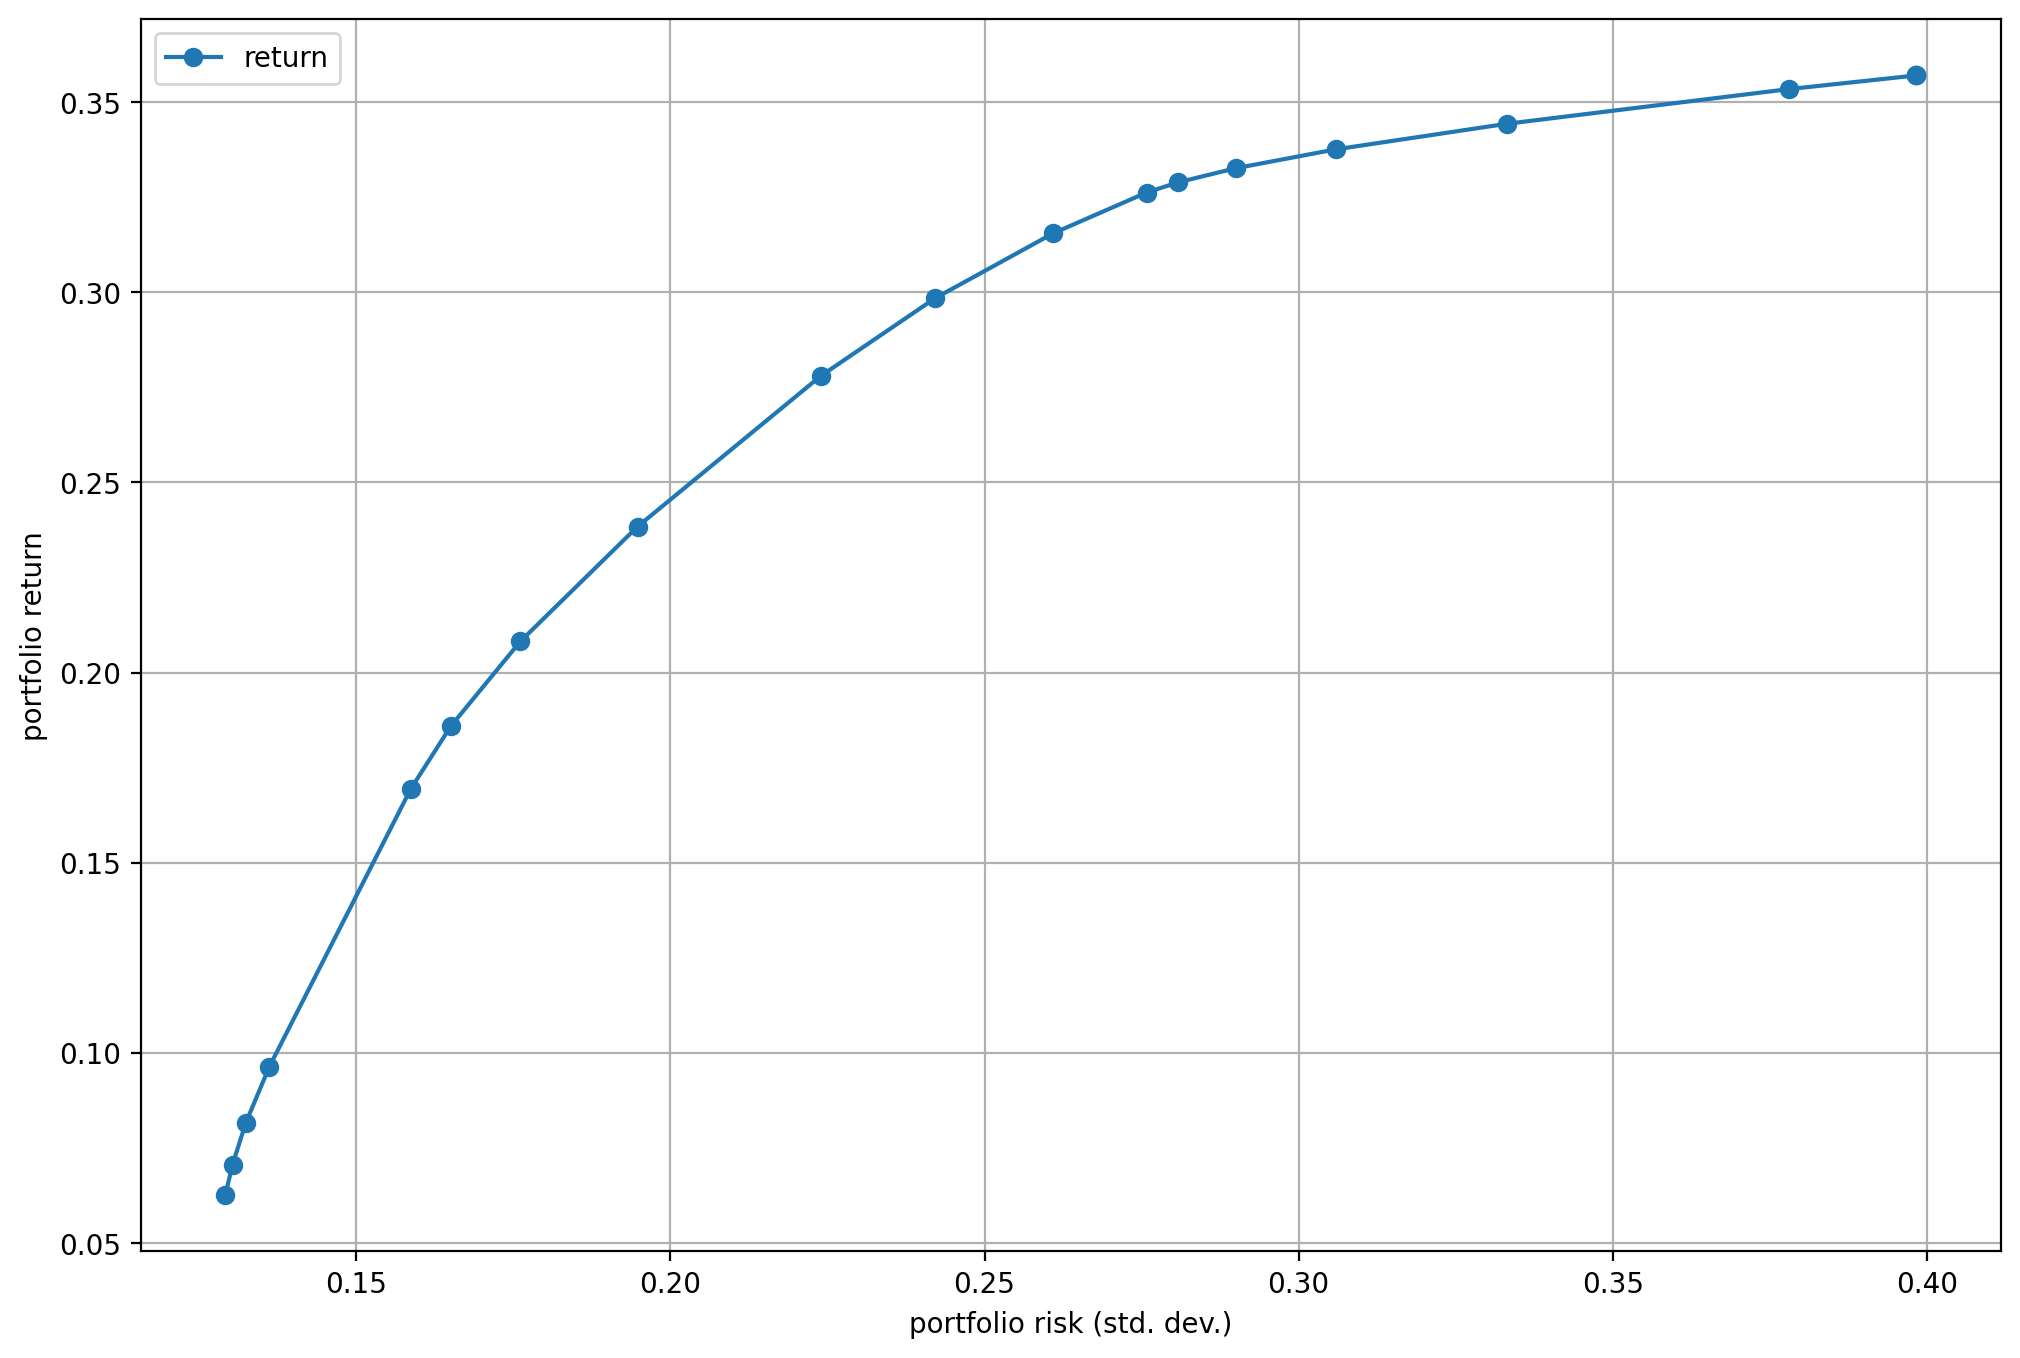

In [23]:
ax = df_result.plot(x="risk", y="return", style="-o",
                    xlabel="portfolio risk (std. dev.)", ylabel="portfolio return", grid=True)
ax.legend(["return"]);

Plot the portfolio composition.

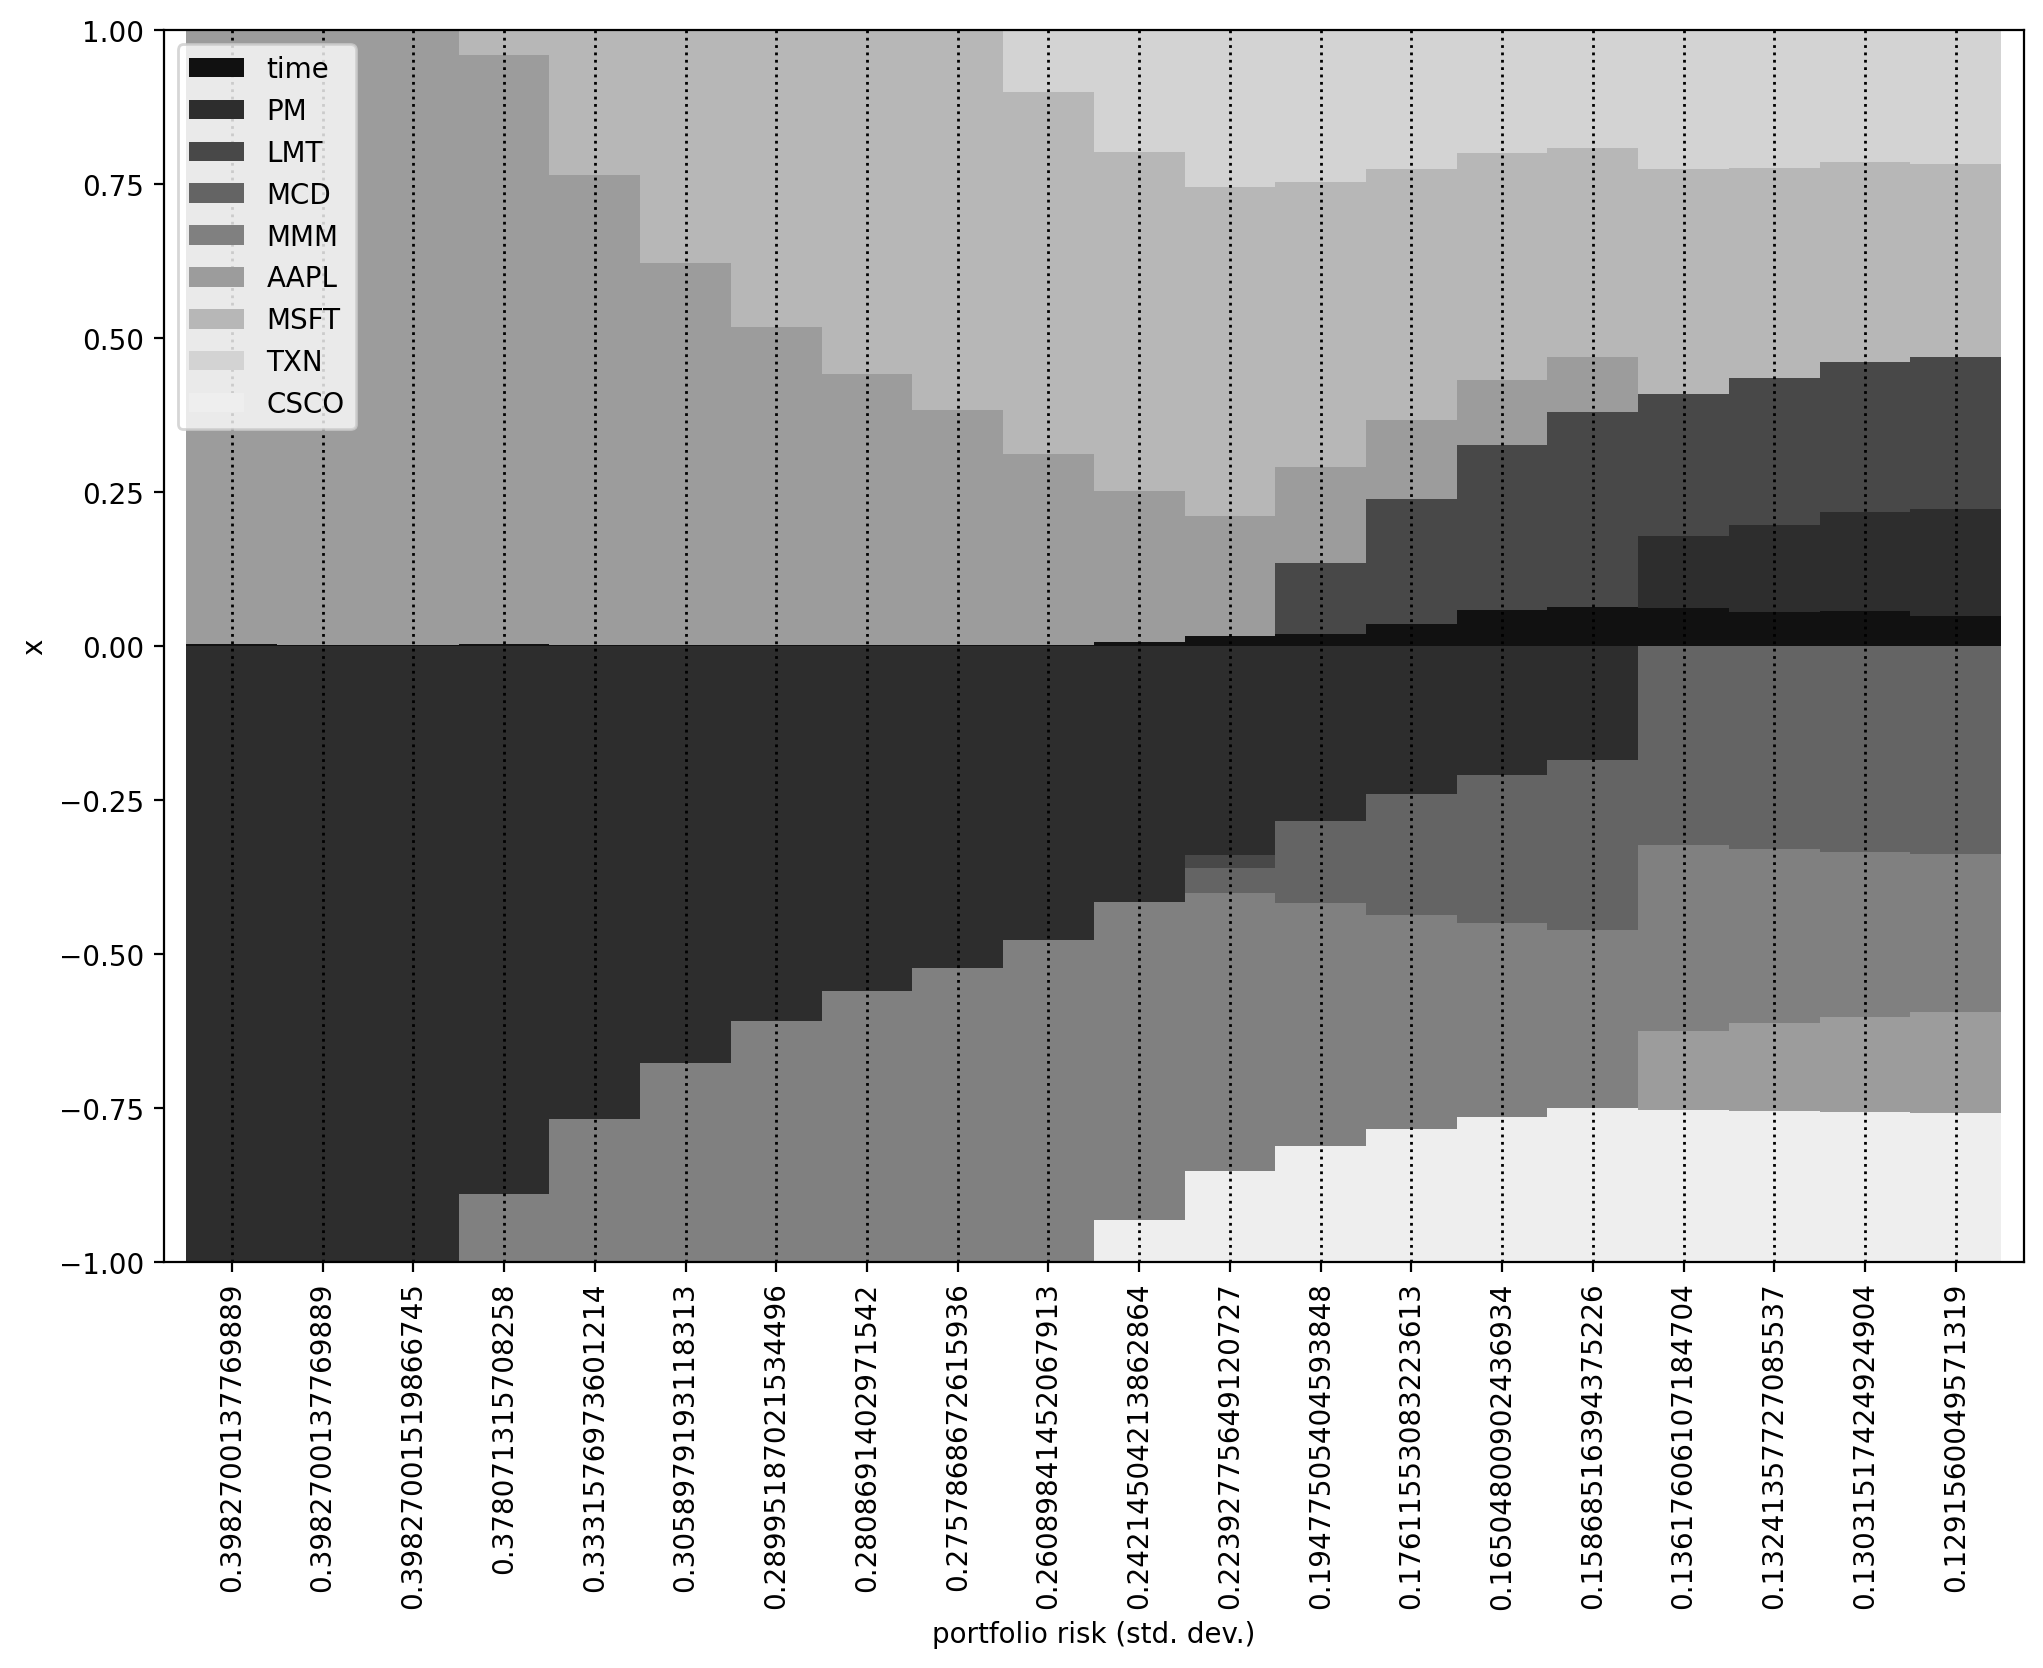

In [24]:
my_cmap = LinearSegmentedColormap.from_list("non-extreme gray", ["#111111", "#eeeeee"], N=256, gamma=1.0)
ax = plt.gca()
ax.set_xticks(df_result['risk'])
df_result.set_index('risk').iloc[:, 4:].plot.bar(ax=ax, colormap=my_cmap, xlabel='portfolio risk (std. dev.)', ylabel="x", stacked=True, width=1.0)
ax.set_ylim([-1, 1])
ax.grid(which='both', axis='x', linestyle=':', color='k', linewidth=1)